# Chapter 5. Fine-tuning Large Language Models

**Note**
As of July 28, 2023, the link to the distribution source of the MARC-ja dataset is broken, and the code posted in sections 5.2, 5.3, and 5.5.4 of the book contains an error in the part where the dataset is read. It's ready to come out. This notebook is prepared to run the same code as in the book using WRIME, a sentiment analysis dataset similar to MARC-ja.

## 5.2 Implementation of Sentiment Analysis Model

### 5.2.1 Preparing the Environment

In [1]:
!pip -q install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# Fix the random seed to 42
set_seed(42)

### 5.2.2 データセットの準備

In [3]:
from pprint import pprint
from datasets import load_dataset

# Load data from the llm-book/wrime-sentiment repository on Hugging Face Hub
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")
# Display in a readable format using pprint
pprint(train_dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [4]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


### 5.2.3 Tokenizer

In [5]:
from transformers import AutoTokenizer

# Specify the model name on Hugging Face Hub
model_name = "cl-tohoku/bert-base-japanese-v3"
# Load the tokenizer from the model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Check the class name of the tokenizer
print(type(tokenizer).__name__)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

BertJapaneseTokenizer


In [6]:
# Tokenize the Japanese phrase "これはテストです。"
# (which translates to "This is a test.")
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [7]:
# Tokenize the Japanese phrase "これはテストです。"
# (which translates to "This is a test.")
encoded_input = tokenizer("これはテストです。")
# Display the class of the outputted object
print(type(encoded_input).__name__)

BatchEncoding


In [8]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [9]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

### 5.2.4 Visualizing Statistics of the Dataset

100%|██████████| 20149/20149 [00:11<00:00, 1702.58it/s]


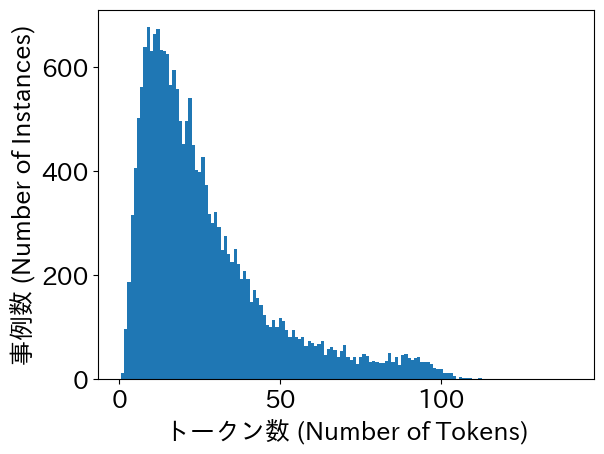

100%|██████████| 1608/1608 [00:02<00:00, 737.15it/s]


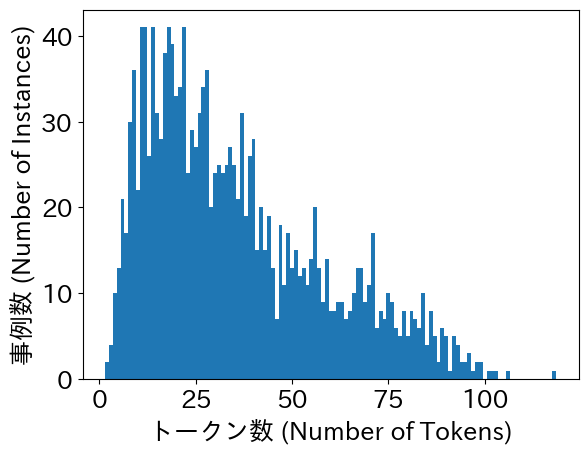

In [10]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # Increase the font size

def visualize_text_length(dataset: Dataset):
    """Draw a graph of the distribution of token counts in texts within the dataset"""
    # Count the lengths of texts in the dataset
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # Draw a bar graph from the values of length_counter
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数 (Number of Tokens)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)


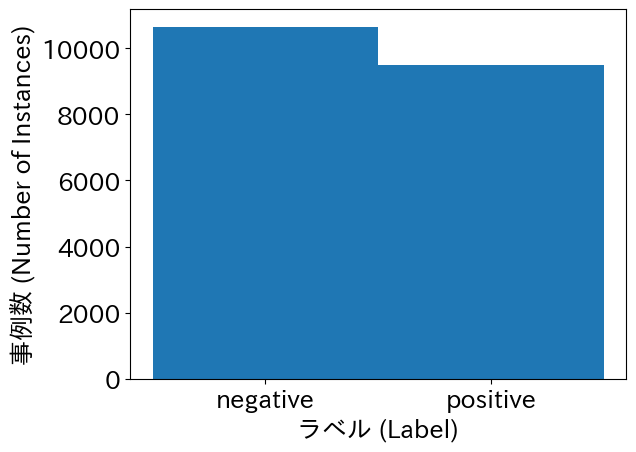

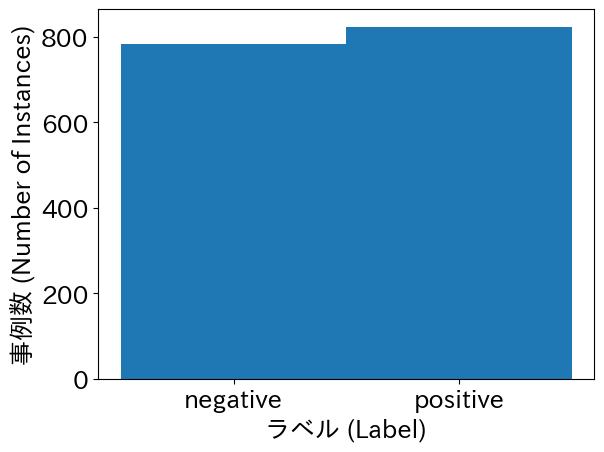

In [11]:
def visualize_labels(dataset: Dataset):
    """Draw a graph of the label distribution in the dataset"""
    # Count the number of labels in the dataset
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # Draw the label_counter as a bar graph
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル (Label)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

### 5.2.5 Preprocessing Dataset

In [12]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """Tokenize the text of the text classification example and convert it to IDs"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # Store under the key "labels", which is an input argument for the model
    encoded_example["labels"] = example["label"]
    return encoded_example

In [13]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/20149 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1608 [00:00<?, ? examples/s]

In [14]:
print(encoded_train_dataset[0])

{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


### 5.2.6 Mini Batch Construction

In [15]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


### 5.2.7 Preparing the Model

In [17]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # Specify the mapping from label names to IDs
    id2label=id2label,  # Specify the mapping from IDs to label names
)
print(type(model).__name__)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [18]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.7499, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0755,  0.1869],
        [ 0.3045,  0.0093],
        [ 0.4099, -0.2517],
        [ 0.3643,  0.2986]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


### 5.2.8 Training Execution

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # Folder to save results
    per_device_train_batch_size=32,  # Batch size during training
    per_device_eval_batch_size=32,  # Batch size during evaluation
    learning_rate=2e-5,  # Learning rate
    lr_scheduler_type="linear",  # Type of learning rate scheduler
    warmup_ratio=0.1,  # Length of learning rate warmup
    num_train_epochs=3,  # Number of training epochs
    save_strategy="epoch",  # Checkpoint save timing
    logging_strategy="epoch",  # Logging timing
    evaluation_strategy="epoch",  # Timing of evaluation with validation set
    load_best_model_at_end=True,  # Load the best model based on the development set after training
    metric_for_best_model="accuracy",  # Metric to determine the best model
    fp16=True,  # Enable automatic mixed precision computation
)

In [20]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """Calculate accuracy from predicted labels and true labels"""
    predictions, labels = eval_pred
    # predictions are the scores for each label
    # The index with the highest score is considered as the predicted label
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [21]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.312300,0.181712,0.924129
2,0.137200,0.184486,0.936567
3,0.068200,0.232514,0.939677


TrainOutput(global_step=1890, training_loss=0.17254348230109642, metrics={'train_runtime': 369.1429, 'train_samples_per_second': 163.75, 'train_steps_per_second': 5.12, 'total_flos': 2739079100166780.0, 'train_loss': 0.17254348230109642, 'epoch': 3.0})

### 5.2.9 Evaluating the Model After Training

In [22]:
# Evaluate the model on the validation set
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9396766169154229,
 'eval_loss': 0.23251397907733917,
 'eval_runtime': 2.4528,
 'eval_samples_per_second': 655.576,
 'eval_steps_per_second': 20.793}


### 5.2.10 Save the Model

Save to Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount("drive")

In [ ]:
# Copy the saved model to a folder in Google Drive
!mkdir -p drive/MyDrive/llm-book-english  # Create the directory llm-book in My Drive if it doesn't exist
!cp -r output_wrime drive/MyDrive/llm-book-english  # Copy the output_wrime folder to the llm-book directory in My Drive

Save to Hugging Face Hub

In [ ]:
from huggingface_hub import login

login()

In [ ]:
# Repository name on Hugging Face Hub
# Replace "YOUR-ACCOUNT" with your own username
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-wrime-sentiment"
# Upload the tokenizer and model
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)